### Imports

In [ ]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_state_qsphere, plot_histogram
from qiskit.quantum_info import Statevector, partial_trace
from qiskit.visualization import plot_bloch_multivector
from qiskit import transpile
import numpy as np
import matplotlib.pyplot as plt
import seaborn
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler
from qiskit.transpiler import generate_preset_pass_manager
from qiskit.circuit.library import UnitaryGate, QFT

from scipy.linalg import ishermitian
from fractions import Fraction
from scipy.linalg import expm

import os
from dotenv import load_dotenv

# HHL algorithm for a 4x4 system

# First define the system

In [24]:
A = np.array([
    [ 0.6, 0.2, 0.0, 0.0],
    [ 0.2, 0.6, 0.0, 0.0],
    [ 0.0, 0.0, 2.2, 0.2],
    [ 0.0, 0.0, 0.2, 2.2]
], dtype=float)

b = np.array([2, 1, 2, 1])

print("Is A Hermitian? : ", ishermitian(A))

Is A Hermitian? :  True


### Check solution ratios

[0.8827683616 0.0353107345 0.0692090395 0.0127118644]


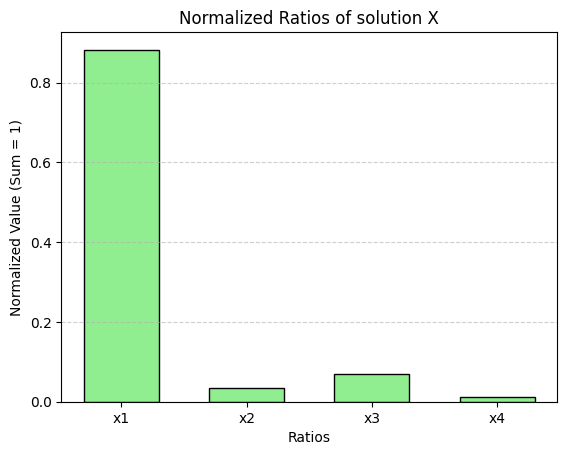

In [25]:

x_num = np.array([25/8, 5/8, 7/8, 3/8])

x = np.linalg.solve(A, b)
x_sq = x**2
x_sq_norm = x_sq / np.sum(x_sq)


x_positions = np.arange(len(x_sq_norm))
labels = ['x1', 'x2', 'x3', 'x4']
plt.bar(x_positions, x_sq_norm, color='lightgreen', edgecolor='black', width=0.6)

# Formatting
plt.xticks(x_positions, labels)  # Map the even positions to our ratio labels
plt.xlabel('Ratios')
plt.ylabel('Normalized Value (Sum = 1)')
plt.title('Normalized Ratios of solution X')
plt.grid(axis='y', linestyle='--', alpha=0.6)

print(x_sq_norm)

### Eigenvalues and Eigenvectors

In [26]:
evals = [0.8, 0.4, 2.4, 2.0]

# Orthonormal eigenvectors as columns:
v1 = (1/np.sqrt(2)) * np.array([1,  1, 0, 0], dtype=float)  # for 0.8
v2 = (1/np.sqrt(2)) * np.array([1, -1, 0, 0], dtype=float)  # for 0.4
v3 = (1/np.sqrt(2)) * np.array([0,  0, 1, 1], dtype=float)  # for 2.4
v4 = (1/np.sqrt(2)) * np.array([0,  0, 1,-1], dtype=float)  # for 2.0

V = np.column_stack([v1, v2, v3, v4])

Lam = np.diag(evals)
A_rec = V @ Lam @ V.T

np.set_printoptions(precision=10, suppress=True)
print("Reconstructed A:\n", A_rec)


Reconstructed A:
 [[0.6 0.2 0.  0. ]
 [0.2 0.6 0.  0. ]
 [0.  0.  2.2 0.2]
 [0.  0.  0.2 2.2]]


# Implement the circuit

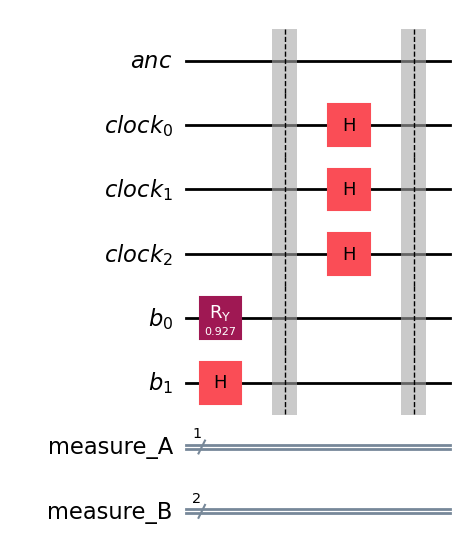

In [27]:
# Define qunatum registers
clock_len = 3
anc = QuantumRegister(1, "anc")
clock = QuantumRegister(clock_len, "clock")
b = QuantumRegister(2, "b")

measureA = ClassicalRegister(1, "measure_A")
measureB = ClassicalRegister(2, "measure_B")
qc = QuantumCircuit(anc, clock, b, measureA, measureB)

# Prepate B vector as quantum state
qc.h(b[1])
theta = 2 * np.arctan(1/2)
qc.ry(theta, b[0])


qc.barrier()

# Apply superposition to clock qubits
qc.h(clock)

qc.barrier()
fig = qc.draw(output="mpl", fold=-1)
display(fig)

### controlled-U

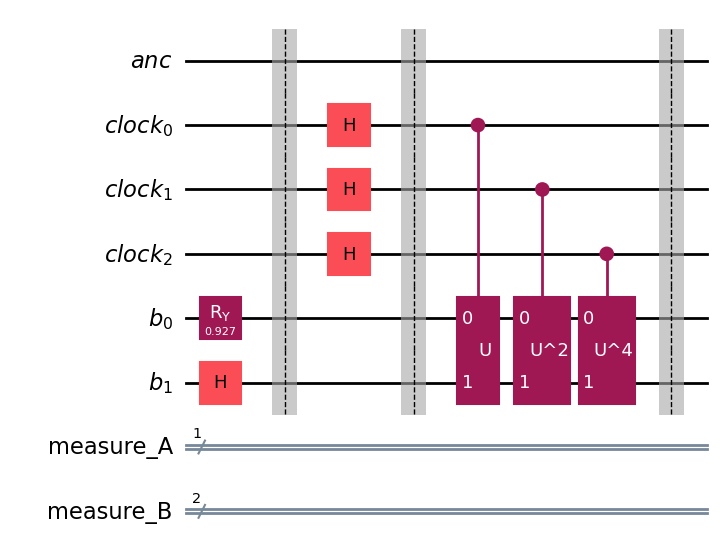

In [28]:
t = 5*np.pi/8
U0 = expm(1j * A * (t))
U1 = expm(1j * A * (2*t))
U2 = expm(1j * A * (4*t))

CU0 = UnitaryGate(U0, label="U").control(1)
CU1 = UnitaryGate(U1, label="U^2").control(1)
CU2 = UnitaryGate(U2, label="U^4").control(1)

qc.append(CU0, [clock[0], b[0], b[1]])
qc.append(CU1, [clock[1], b[0], b[1]])
qc.append(CU2, [clock[2], b[0], b[1]])

qc.barrier()
fig = qc.draw(output="mpl", fold=-1)
display(fig)

### QFT and IQFT circuits

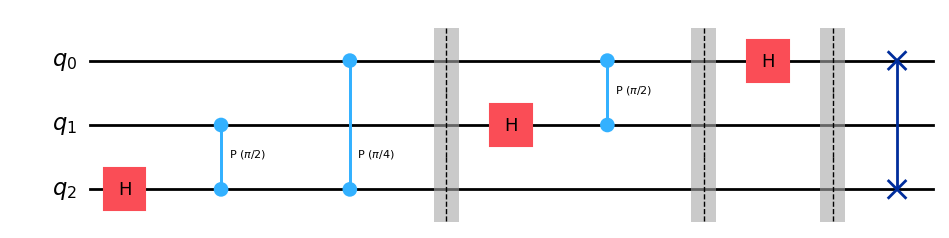

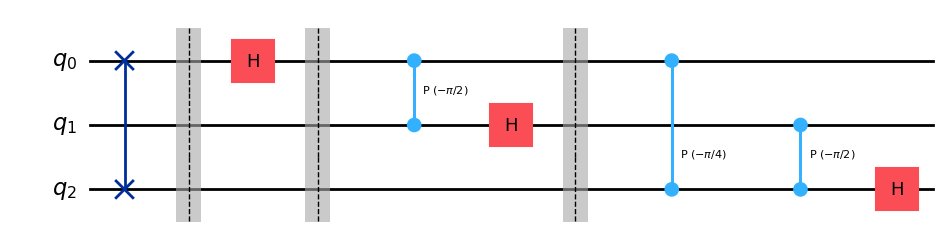

In [29]:
n_qubits = 3

qft = QuantumCircuit(n_qubits)

for n in range(1, n_qubits + 1):
    j = n_qubits - n
    qft.h(j)
    for i in reversed(range(j)):
        theta = np.pi / (2 ** (j - i))
        qft.cp(theta, i, j)
    qft.barrier()

def add_swap_gates(qc_swaps, qubits):
    for qubit in range(qubits//2):
        qc_swaps.swap(qubit, qubits-qubit-1)
    return qc_swaps


qft = add_swap_gates(qft, n_qubits)
iqft = qft.inverse()


fig = qft.draw(output="mpl", fold=-1)
display(fig)

fig = iqft.draw(output="mpl", fold=-1)
display(fig)

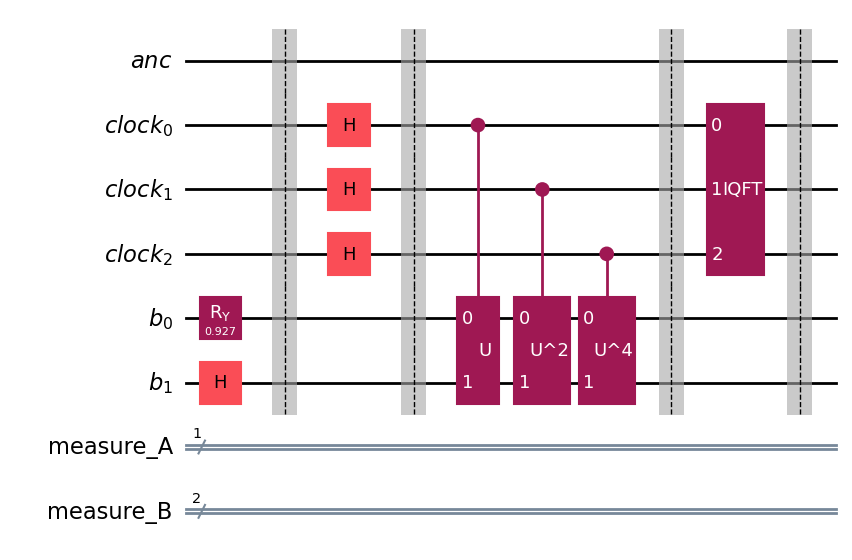

In [30]:
# Add the IQFT to clock register
iqft_inst = iqft.to_instruction()
iqft_inst.name = "IQFT"
qc.append(iqft_inst, clock)

qc.barrier()
fig = qc.draw(output="mpl", fold=-1)
display(fig)


### Controlled-rotation of ancilla qubit

### encode the eigenvalues as states of the clock register

In [31]:
L_tilda = [1, 2, 5, 6]

theta_1 = 2 * np.arcsin(1/1)
theta_2 = 2 * np.arcsin(1/2)
theta_5 = 2 * np.arcsin(1/5)
theta_6 = 2 * np.arcsin(1/6)

print(theta_1)


3.141592653589793


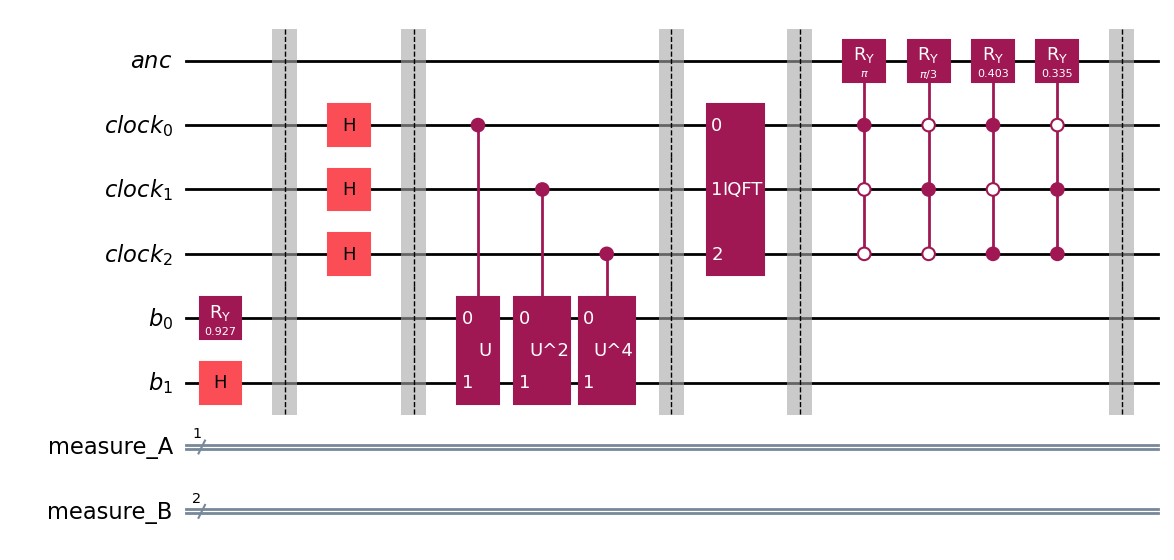

In [32]:
theta_map = {
    "001": 2*np.arcsin(1/1),
    "010": 2*np.arcsin(1/2),
    "101": 2*np.arcsin(1/5),
    "110": 2*np.arcsin(1/6),
}


from qiskit.circuit.library import RYGate

controls = [clock[0], clock[1], clock[2]]

for bitstr, theta in theta_map.items():
    gate = RYGate(theta).control(num_ctrl_qubits=3, ctrl_state=int(bitstr, 2))
    qc.append(gate, [clock[0], clock[1], clock[2], anc[0]])


qc.barrier()
fig = qc.draw(output="mpl", fold=-1)
display(fig)

### Measure the ancilla qubit

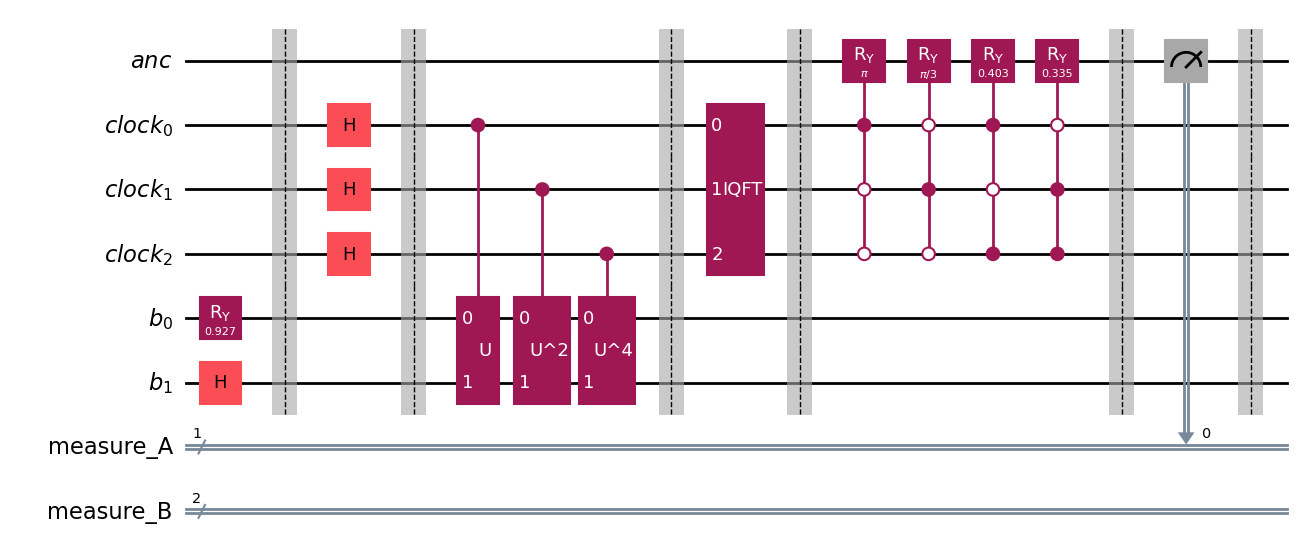

In [33]:
qc.measure(anc[0], measureA[0])

qc.barrier()
fig = qc.draw(output="mpl", fold=-1)
display(fig)

### QFT

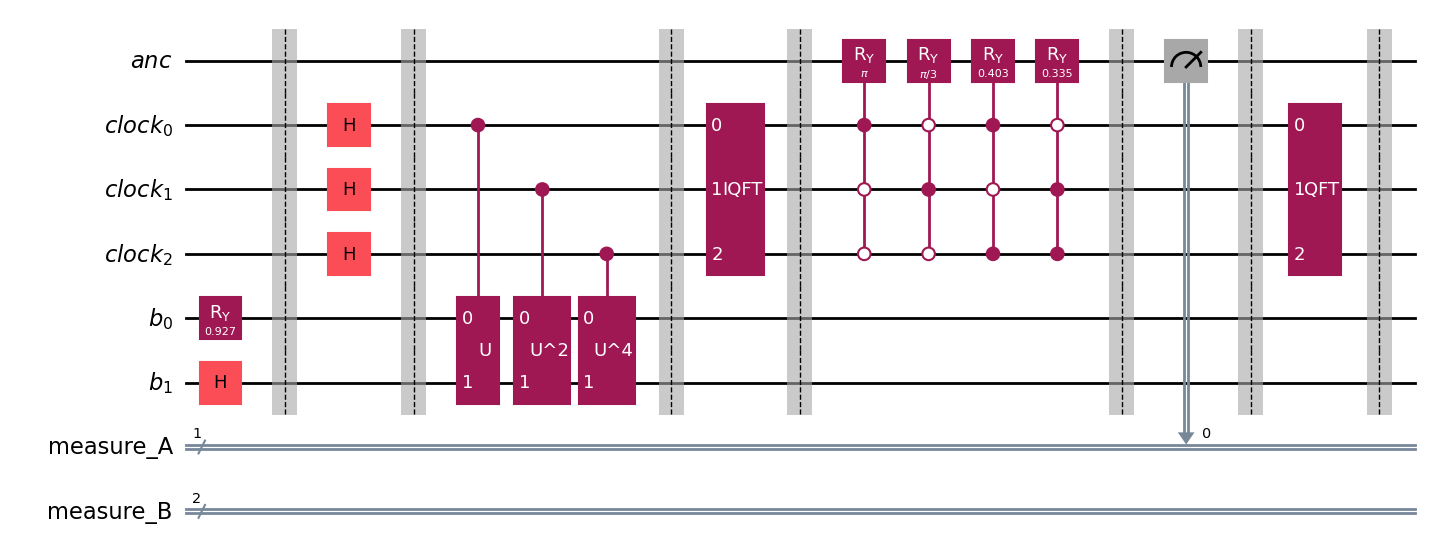

In [34]:
qft_inst = qft.to_instruction()
qft_inst.name = "QFT"
qc.append(qft_inst, clock)

qc.barrier()
fig = qc.draw(output="mpl", fold=-1)
display(fig)

### inverse controlled-U

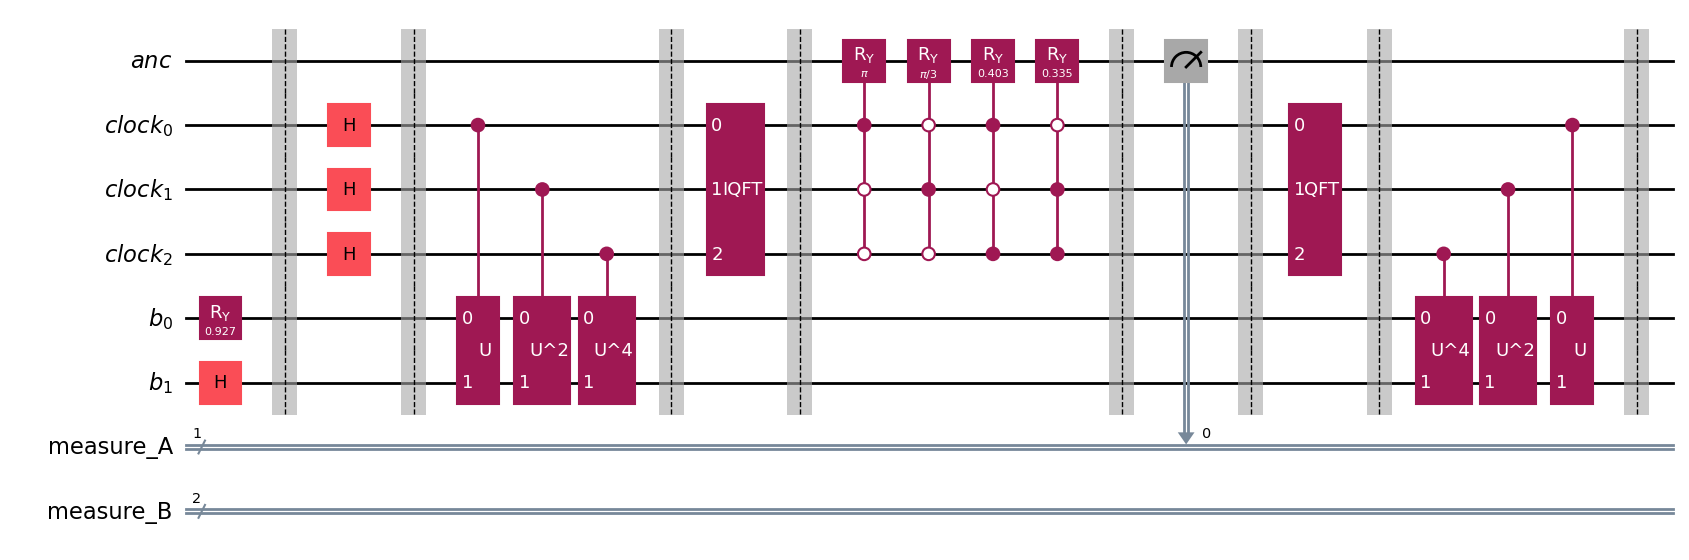

In [35]:
U0_dag = expm(-1j * A * t)
U1_dag = expm(-1j * A * (2*t))
U2_dag = expm(-1j * A * (4*t))

CU0_dag = UnitaryGate(U0_dag, label="U").control(1)
CU1_dag = UnitaryGate(U1_dag, label="U^2").control(1)
CU2_dag = UnitaryGate(U2_dag, label="U^4").control(1)

# After your QFT(clock):
qc.append(CU2_dag, [clock[2], b[0], b[1]])
qc.append(CU1_dag, [clock[1], b[0], b[1]])
qc.append(CU0_dag, [clock[0], b[0], b[1]])

qc.barrier()
fig = qc.draw(output="mpl", fold=-1)
display(fig)

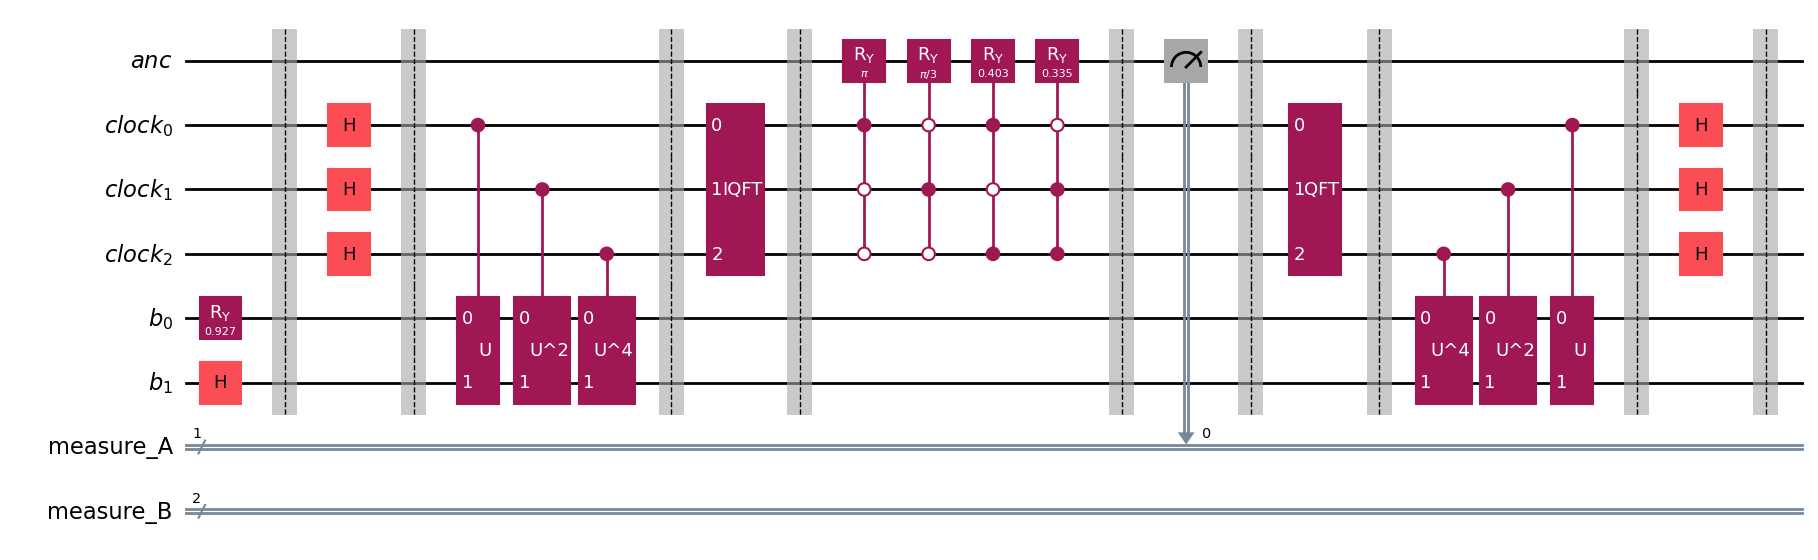

In [36]:
# Then Hadamards to finish uncomputing:
qc.h(clock)
qc.barrier()
fig = qc.draw(output="mpl", fold=-1)
display(fig)


### measure B

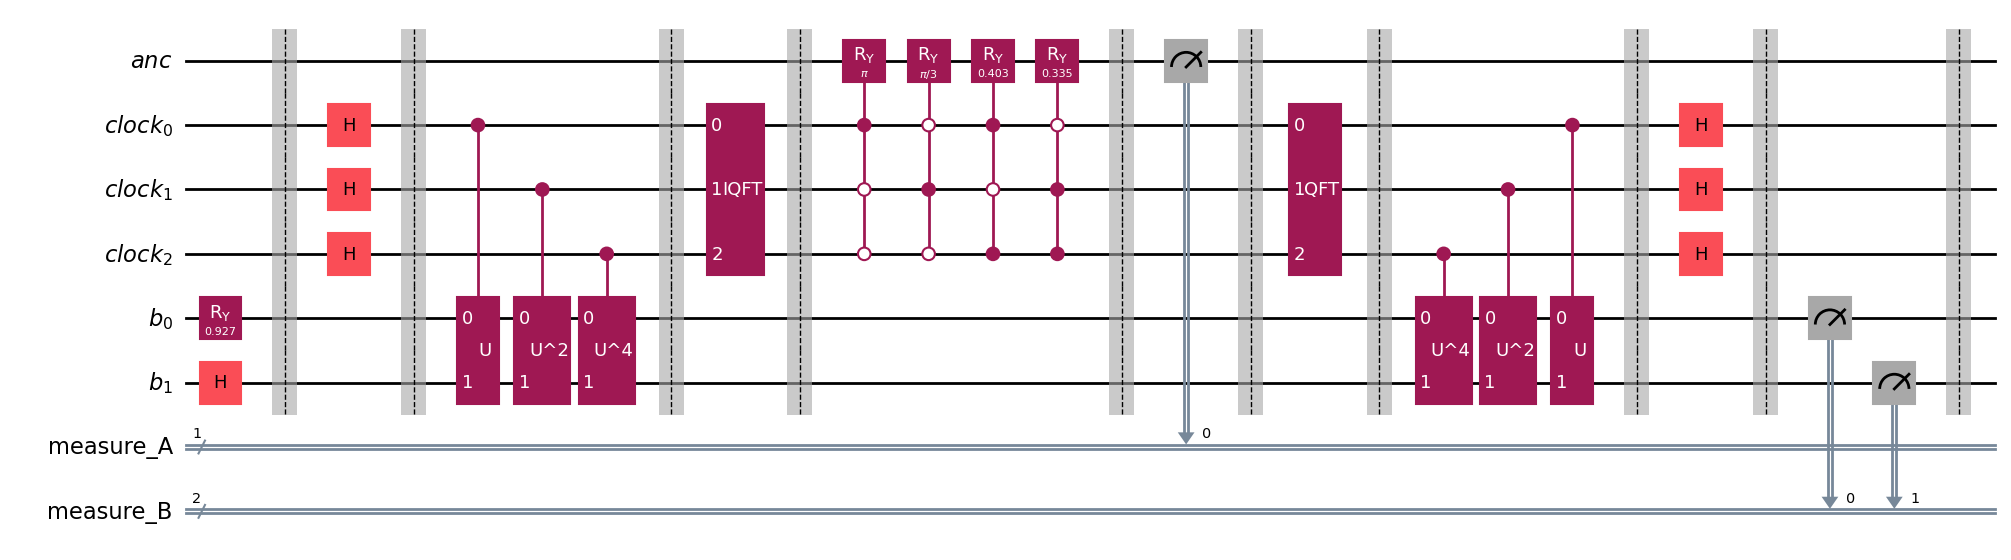

In [37]:
qc.measure([b[0], b[1]], [measureB[0], measureB[1]])

qc.barrier()
fig = qc.draw(output="mpl", fold=-1)
display(fig)

# Run simulation

Simulation Counts: {'10 1': 12166, '01 1': 6282, '11 1': 2273, '00 1': 156281, '00 0': 168182, '01 0': 169702, '11 0': 97567, '10 0': 387547}


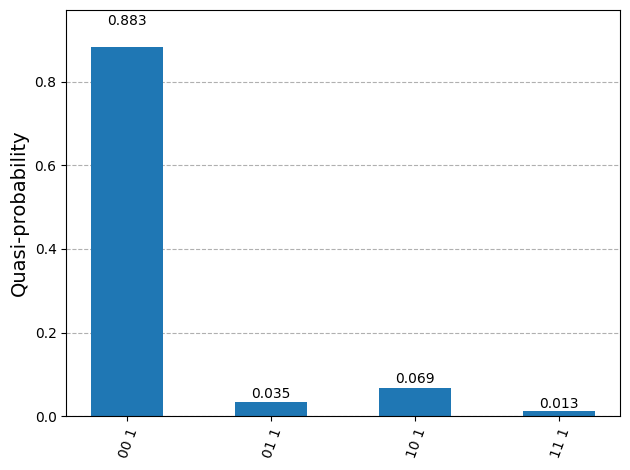

Sum = 1.0


In [38]:
simulator = AerSimulator()
compiled_circuit = transpile(qc, simulator)
job = simulator.run(compiled_circuit, shots=1_000_000)
result = job.result()
counts = result.get_counts(compiled_circuit)
print("Simulation Counts:", counts)


counts_anc1 = {k: v for k, v in counts.items() if k.split()[-1] == "1"}

total_anc1 = sum(counts_anc1.values())
counts_anc1_norm = {k: v / total_anc1 for k, v in counts_anc1.items()} if total_anc1 else {}

fig = plot_histogram(counts_anc1_norm)
display(fig)

print("Sum =", sum(counts_anc1_norm.values()))

# Running on real quantum hardware

### connect to IBM

In [ ]:
load_dotenv()

API_KEY = os.getenv('API_KEY')
QISKIT_IBM_INSTANCE_CRN = os.getenv('QISKIT_IBM_INSTANCE_CRN')
QISKIT_IBM_CHANNEL = os.getenv('QISKIT_IBM_CHANNEL')

In [40]:
QiskitRuntimeService.save_account(channel=QISKIT_IBM_CHANNEL, token=API_KEY, instance=QISKIT_IBM_INSTANCE_CRN, overwrite=True)
service = QiskitRuntimeService()

In [41]:
backend = service.least_busy(operational=True, simulator=False, min_num_qubits=1)

In [42]:
print(backend)

<IBMBackend('ibm_torino')>


### Prepare circuit for running on IBM

In [43]:
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
qc_ibm = pm.run(qc)

In [ ]:
# sampler = Sampler(mode=backend)
# sampler.options.default_shots = 2_000_000
# results = sampler.run([qc_ibm]).result() 

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt

data = results[0].data
A = data.measure_A   
B = data.measure_B  

A_bits = A.to_bool_array(order="little")  
B_bits = B.to_bool_array(order="little") 

import numpy as np
A_bits = np.asarray(A_bits).reshape(-1, 1)
B_bits = np.asarray(B_bits)
if B_bits.ndim > 2:
    B_bits = B_bits.reshape(B_bits.shape[0], -1)

mask = A_bits[:, 0]

B_filt = B_bits[mask]
b_strings = ["".join("1" if bit else "0" for bit in row[:2]) for row in B_filt]

counts = Counter(b_strings)

labels = ["00", "01", "10", "11"]
values = [counts.get(k, 0) for k in labels]


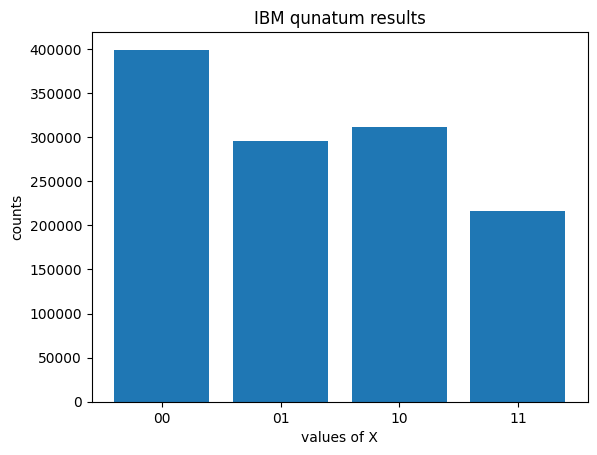

In [63]:
plt.bar(labels, values)
plt.xlabel("values of X")
plt.ylabel("counts")
plt.title("IBM qunatum results")
plt.show()